In [99]:
from __future__ import division

import os
import numpy as np
import pandas as pd
import cv2
from skimage import io, exposure
from skimage.feature import canny
from skimage.measure import label, regionprops
from skimage.filters import threshold_local,threshold_adaptive
from skimage.morphology import remove_small_objects
from skimage.util import pad
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv('../data/train.csv')
train.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [3]:
train['id'].duplicated().any()

False

In [4]:
train.describe()

,id,boneage
count,12611.000000,12611.000000
mean,8537.653001,127.320752
std,4108.763993,41.182021
min,1377.000000,1.000000
25%,5074.500000,96.000000
50%,8565.000000,132.000000
75%,12091.500000,156.000000
max,15610.000000,228.000000


In [5]:
train[train['male']==True].describe()

,id,boneage
count,6833.000000,6833.000000
mean,8491.921557,135.303673
std,4103.709986,42.143162
min,1380.000000,1.000000
25%,5051.000000,108.000000
50%,8500.000000,150.000000
75%,12048.000000,162.000000
max,15610.000000,228.000000


In [6]:
train[train['male']==False].describe()

,id,boneage
count,5778.000000,5778.000000
mean,8591.734510,117.880235
std,4114.431989,37.908112
min,1377.000000,4.000000
25%,5117.250000,94.000000
50%,8626.000000,120.000000
75%,12137.500000,144.000000
max,15608.000000,216.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc23c706550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc23c69a910>], dtype=object)

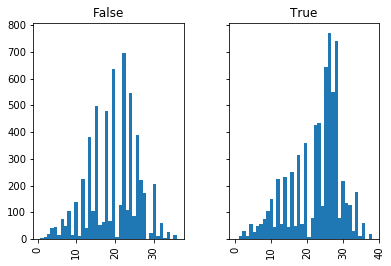

In [7]:
a = train['boneage'] / 6
a.hist(bins=40, by=train['male'], sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc23c5321d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc23c2864d0>], dtype=object)

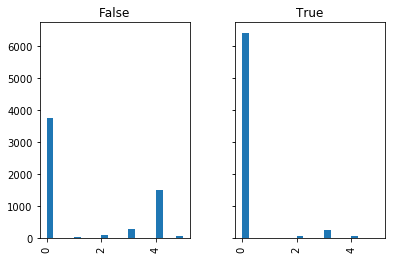

In [8]:
a = train['boneage'] % 6
a.hist(bins=20, by=train['male'], sharey=True)

In [9]:
val = pd.read_csv('../data/dataset_data_file-validation-gender-fa677c87-bd0d-44a1-92f3-f5966389798b.csv')
val['id'].duplicated().any()

False

In [10]:
val.groupby('male').count()

,id
male,
False,652
True,773


In [11]:
val.head()

,id,male
0,1386,False
1,1392,True
2,1397,False
3,1401,False
4,1410,True


In [12]:
len(list(set(train['id']) & set(val['id'])))

0

In [13]:
sub = pd.read_csv('../data/submission-rand.csv')

In [14]:
len(list(set(sub['id']) & set(train['id'])))

12611

In [15]:
len(list(set(sub['id']) & set(val['id'])))

0

In [16]:
train['x'] = 0
train['y'] = 0

img_idx = []

for filename in os.listdir('../data/boneage-training-dataset/'):
    if filename.endswith(".png"):
        img_idx.append(filename[:-4])
#         print(train.loc[train['id'] == int(img[:-4]), 'x'])
#         train.loc[train['id'] == int(img[:-4]), 'x'] = 1
#         print(train.loc[train['id'] == int(img[:-4]), 'x'])
        img = io.imread(os.path.join('../data/boneage-training-dataset/', filename))
        train.loc[train['id'] == int(filename[:-4]), 'x'], train.loc[train['id'] == int(filename[:-4]), 'y'] = img.shape

KeyboardInterrupt: 

In [ ]:
train['x'].hist()

In [ ]:
train['y'].hist()

In [102]:
img = cv2.imread(os.path.join('../data/boneage-training-dataset/', str(train[train['boneage']==10]['id'].values[0]) + '.png'))
img.shape
img = img[:,:,::-1]
img.shape

(837, 871, 3)

(837, 871)


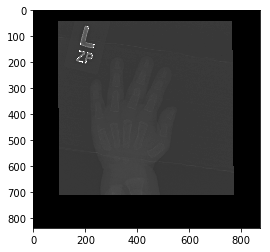

In [90]:
img = io.imread(os.path.join('../data/boneage-training-dataset/', str(train[train['boneage']==10]['id'].values[0]) + '.png'))
print(img.shape)
# img[img>150]=np.mean(img)
# img[img<50]=0
plt.figure()
plt.imshow(img, cmap=plt.cm.gray)

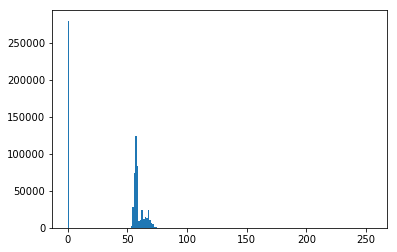

In [91]:
plt.figure()
plt.hist(img.ravel(), bins='auto')
plt.show()

In [92]:
# # Contrast stretching
# p2, p98 = np.percentile(img, (2, 98))
# img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# # Equalization
# img_eq = exposure.equalize_hist(img)

# # Adaptive Equalization
# img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# plt.figure()
# plt.imshow(img_rescale, cmap=plt.cm.gray)

# plt.figure()
# plt.imshow(img_eq, cmap=plt.cm.gray)

# plt.figure()
# plt.imshow(img_adapteq, cmap=plt.cm.gray)

(837, 871)


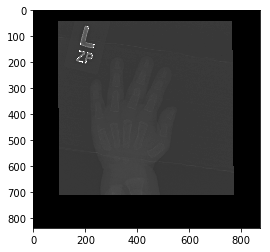

In [95]:
# ba_img = threshold_adaptive(img_rescale, np.max(img.shape)/2, offset=10)
# pad_img = pad(smo_img, 1, 'constant', constant_values=1)
# fh_img = ndi.binary_fill_holes(pad_img)
ba_img = img*(img>50)
print(ba_img.shape)
plt.figure()
plt.imshow(ba_img, cmap=plt.cm.gray)

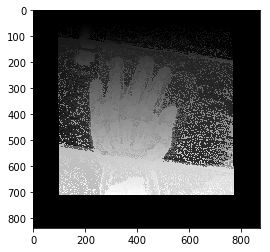

In [96]:
img_lab = label(ba_img)
# img_lab = remove_small_objects(ba_img, np.max(img.shape)/2)
plt.figure()
plt.imshow(img_lab, cmap=plt.cm.gray)

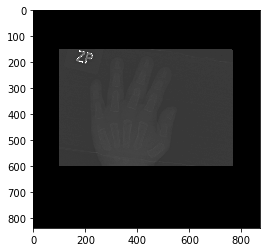

In [97]:
props = regionprops(img_lab)
areas = [prop.area for prop in props]
bbox = props[np.argmax(areas)].bbox

img_mask = np.zeros(img.shape, dtype=np.uint8)
img_mask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]

plt.figure()
plt.imshow(img_mask, cmap=plt.cm.gray)

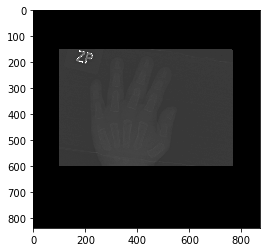

In [98]:
img_mask_eq = exposure.equalize_adapthist(img_mask, clip_limit=0.03)
plt.figure()
plt.imshow(img_mask, cmap=plt.cm.gray)